# **Forecasting Carbon Allowance Prices Across Five Emissions Trading Systems Using Deep Learning (2017-2023)**
| <H1>MScFE 690: Capstone</H1><H2><i>Final Project</i> - Student Group 5481</H2> | <img src="https://learn.wqu.edu/assets/39cecb6f6bdccec67223.svg" alt="WQU">               |
|:-------------|--------------------:|

|        FULL LEGAL NAME       |  LOCATION |           EMAIL ADDRESS          | CONTRIBUTING |
|:----------------------------:|:-------------------:|:--------------------------------:|:--------------------------------------:|
| Artis Jhamar Johnson | USA               | jammervp@gmail.com          |                                        |
| Pranav Ramkumar          | USA              | pranavramkumar@gmail.com             |                                        |
| Ekoue Jean Kougnah        | Togo               | kougnahe@gmail.com |                                        |

<h3>Statement of integrity:</h3>

| Team member | By typing the names of all group members in the text boxes below,<br> you confirm that the assignment submitted is original work produced by the group<br> (excluding any non-contributing members identified with an “X” above).               |
|:-------------|:--------------------:|
| A | Artis Jhamar Johnson |
| B | Pranav Ramkumar            |
| C | Ekoue Jean Kougnah               |

## Libraries Needed

In [ ]:
!pip install CEEMDAN_LSTM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
  Created wheel for CEEMDAN_LSTM: filename=CEEMDAN_LSTM-1.2-py3-none-any.whl size=416911 sha256=c8a04c76af440a53af8b7f2ea60d328aa7862b6f82d694678c2dc2ae74624c2a
  Stored in directory: /root/.cache/pip/wheels/4c/b3/d9/0bb90c1a3

In [ ]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import xgboost as xgb
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import CEEMDAN_LSTM as cl
import matplotlib.pyplot as plt
import datetime as dt

from torch import nn
from numpy import mean
from numpy import std
from math import sqrt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from CEEMDAN_LSTM.core import check_dataset, check_path, plot_save_result, name_predictor, output_result
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

### Google Drive Link if needed

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data Set Up

In [ ]:
def DataForm(ETS,TT_Split):
  '''
  Inputs:
  ETS - Name of the ETS System (str)
  TT_Split - The test/train split for the data as a decimal (float)

  '''
  # Read CSV file for features and outputs
  file = pd.read_csv("{}.csv".format(ETS),parse_dates=['Date'], index_col=['Date'])

  # Seperate to X and Y values
  X = pd.DataFrame(file.drop(["Y"],axis=1)).astype(float)
  Y = pd.DataFrame(file.drop(['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14'],axis=1)).astype(float)

  # Split the Data into Test, Train, and Unseen
  cutoff = -int(len(X)*TT_Split)

  # X_train, X_test, Y_train, Y_test = train_test_split(X[:-cutoff], Y[:-cutoff], test_size=2*TT_Split, random_state=42)
  # # Train Data
  X_train = X[:2*cutoff]
  Y_train = Y[:2*cutoff]

  # # Test Data
  X_test = X[2*cutoff:cutoff]
  Y_test = Y[2*cutoff:cutoff]


  X_unseen = pd.DataFrame(X[cutoff:])
  Y_unseen = pd.DataFrame(Y[cutoff:])

  return X, Y, X_train, X_test, Y_train, Y_test, X_unseen, Y_unseen, -cutoff

In [ ]:
markets = ["RGGI","CA","Korea","EU","China"]
X, Y, X_train, X_test, Y_train, Y_test, X_unseen, Y_unseen, cutoff = DataForm("China", .15)

In [ ]:
# X_train

##CEEMDAN-LSTM

In [ ]:
def CL_MODEL(data, cutoff):
  data = pd.Series(data['Y'])
  df_ceemdan = cl.decom(data)
  df_ceemdan.plot(title='CEEMDAN Decomposition', subplots=True, figsize=(6, 1*(df_ceemdan.columns.size))) # plot
  plt.show()

  model = Sequential()
  model.add(LSTM(250, input_shape=(2556, 9), activation='tanh'))
  model.add(Dropout(0.5))
  model.add(Dense(1,activation='tanh'))
  model.compile(loss='mse', optimizer='adam')
  kr = cl.keras_predictor(KERAS_MODE=model, FORECAST_HORIZONS=cutoff, FORECAST_LENGTH=cutoff)

  print('\n1.Sample Entropy Calculate')
  print('-------------------------------')
  df_sampen = cl.inte_sampen(df_ceemdan)
  df_sampen.plot(title='Sample Entropy') # plot
  plt.show() # plot

  print('\n2.K-Means Cluster by Sample Entropy')
  print('-------------------------------')
  df_integrate_form = cl.inte_kmeans(df_sampen)
  print(df_integrate_form) # show

  print('\n3.Integrate IMFs')
  print('-------------------------------')
  df_integrate_result = cl.inte(df_ceemdan, df_integrate_form)
  df_integrate_result = df_integrate_result[0]
  df_integrate_result.plot(title='Integrated IMFs (Co-IMFs) of CEEMDAN', subplots=True, figsize=(6,3)) # plot
  plt.show() # plot

  print('\n4.Predict Co-IMF0 thru Co-IMF8 by vector-input LSTM (respective method)')
  series_add_predict_result=pd.DataFrame()
  for IMF in df_integrate_result.drop(['target'],axis=1):
    raw, evaluation, train_loss = kr.keras_predict(df_integrate_result[str(IMF)])
    print('======{} Predicting Finished======\n'.format(str(IMF)), evaluation) # show
    raw.plot(title='{} Predicting Result'.format(str(IMF))) # plot
    train_loss.plot(title='{} Training Loss'.format(str(IMF))) # plot
    series_add_predict_result[str(IMF)]=raw['predict']
  series_add_predict_result=series_add_predict_result.sum(axis=1)
  forecast_length = len(raw)
  df_add_predict_raw = pd.DataFrame({'predict': series_add_predict_result.values, 'raw': data[-forecast_length:].values}, index=range(forecast_length))
  df_add_evaluation = cl.eval_result(data[-forecast_length:],series_add_predict_result)

  print('\n9. Add the result to get the final forecasting results (30 days)')
  print('-------------------------------')
  print('======Hybrid CEEMDAN-LSTM Keras Forecasting Finished======\n', df_add_evaluation) # show
  df_add_predict_raw.plot(title='Hybrid CEEMDAN-LSTM Keras Forecasting Result') # plot
  plt.show() # plot

  # Evaluation Stats
  print("Mean Absolute Error : " + str(mean_absolute_error(data[-forecast_length:],series_add_predict_result)))
  print("Root Mean Squared Error : " + str(sqrt(mean_squared_error(data[-forecast_length:],series_add_predict_result))))
  print("Mean Absolute Percentage Error : " + str(mean_absolute_percentage_error(data[-forecast_length:],series_add_predict_result)))

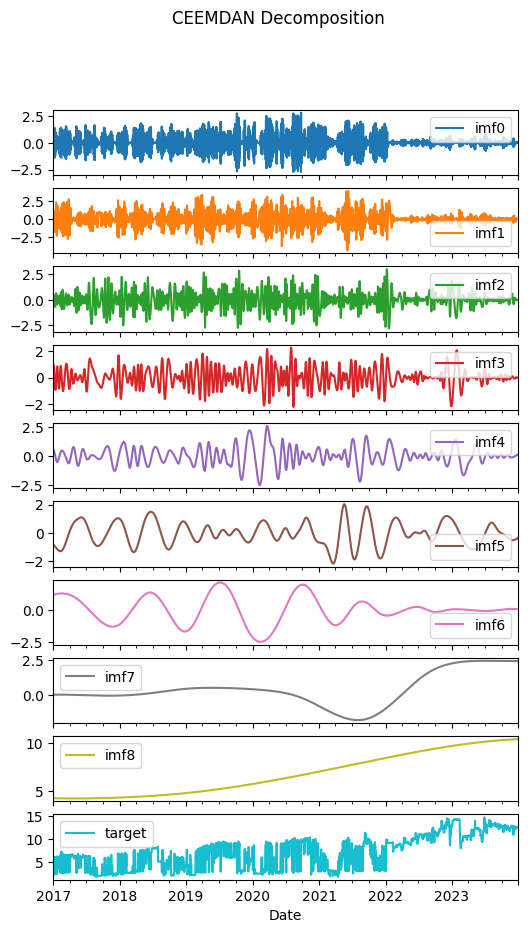


1.Sample Entropy Calculate
-------------------------------


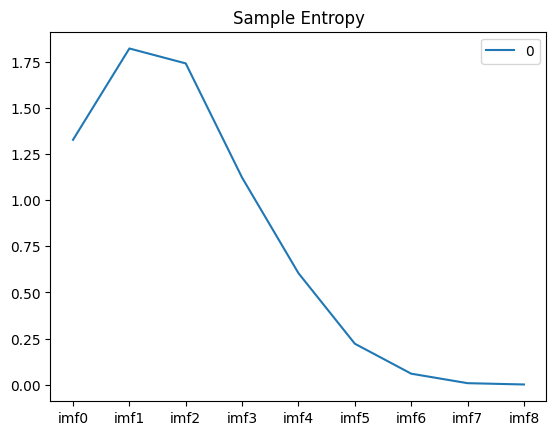


2.K-Means Cluster by Sample Entropy
-------------------------------
None

3.Integrate IMFs
-------------------------------


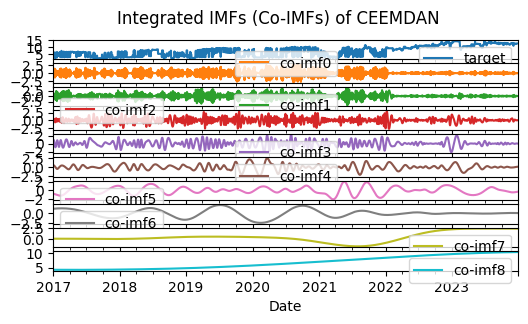


4.Predict Co-IMF0 thru Co-IMF8 by vector-input LSTM (respective method)
======co-imf0 Predicting Finished======
       Scale      R2      RMSE      MAE      MAPE
0  0.807661 -0.0031  0.160376  0.10092  1.602209
======co-imf1 Predicting Finished======
       Scale        R2      RMSE       MAE      MAPE
0  1.024072  0.928789  0.065332  0.046713  0.816823
======co-imf2 Predicting Finished======
       Scale        R2      RMSE       MAE      MAPE
0  0.653868  0.995255  0.011442  0.008385  0.207917
======co-imf3 Predicting Finished======
      Scale        R2      RMSE       MAE      MAPE
0  0.13538  0.931545  0.009478  0.007774  0.595417
======co-imf4 Predicting Finished======
       Scale        R2      RMSE       MAE      MAPE
0  0.202396  0.994057  0.005595  0.004466  0.183144
======co-imf5 Predicting Finished======
       Scale        R2      RMSE       MAE      MAPE
0  0.173724  0.982227  0.007233  0.007037  0.015686
======co-imf6 Predicting Finished======
       Scale        R2   

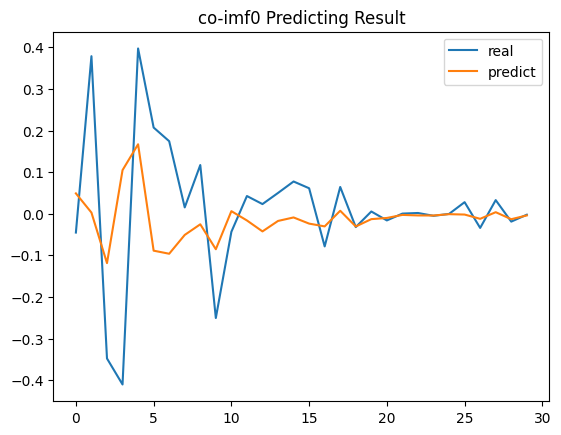

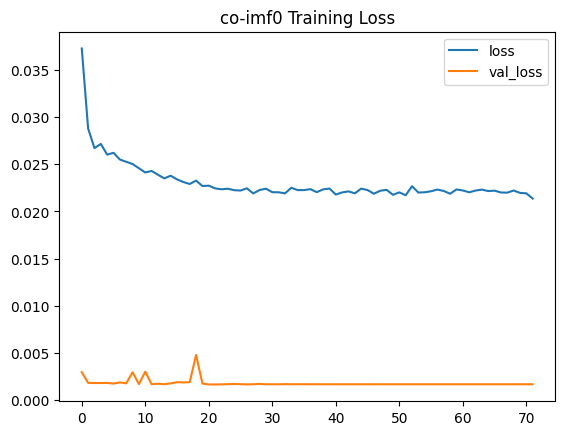

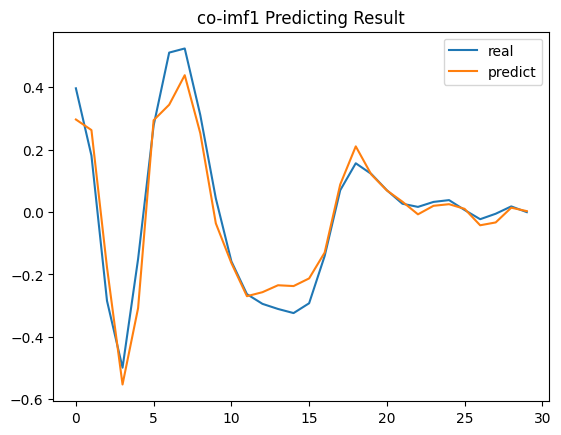

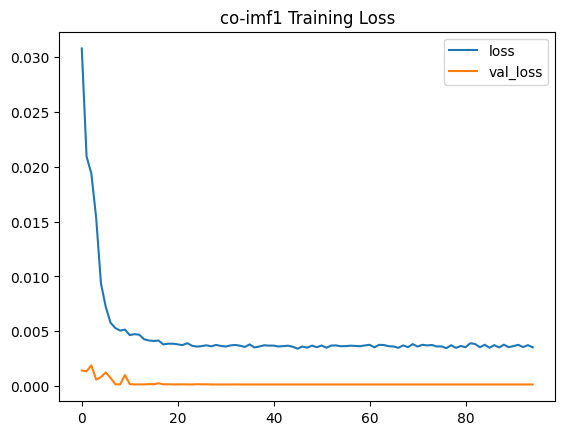

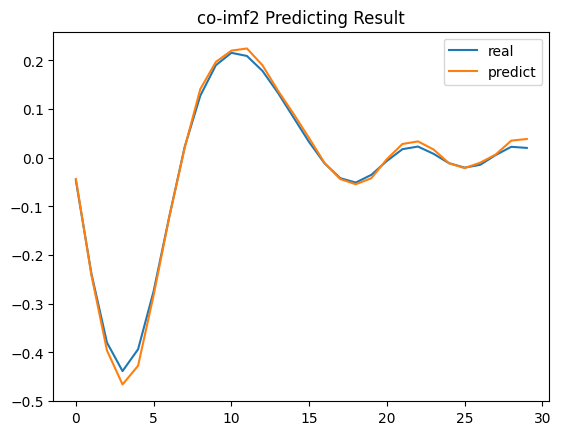

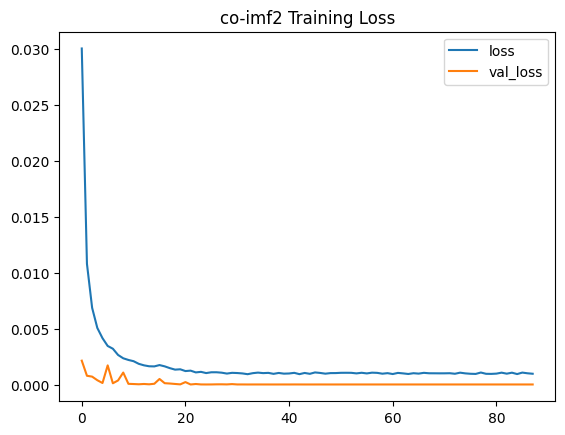

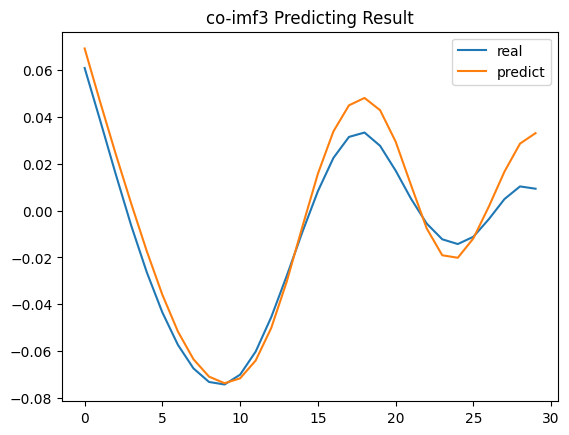

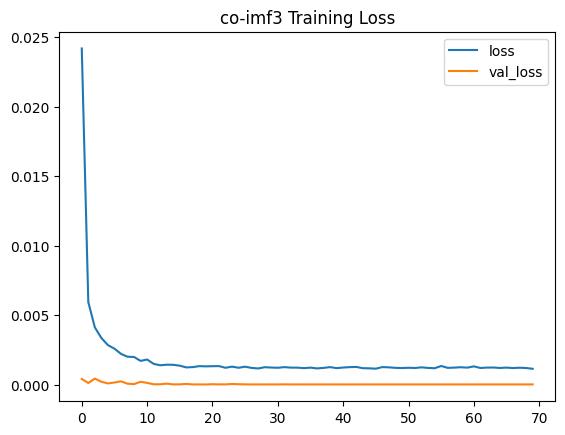

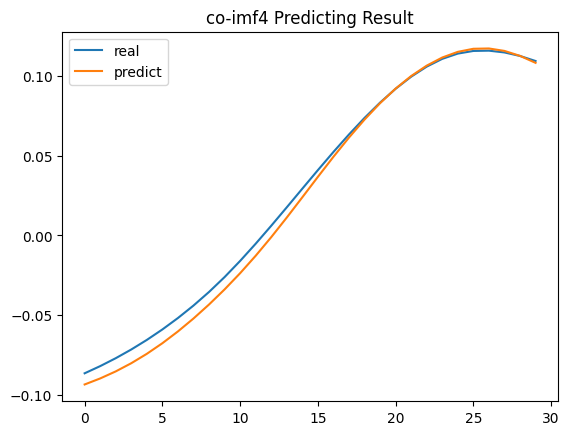

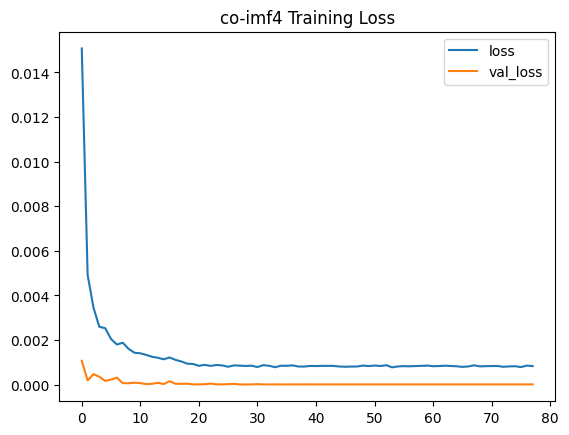

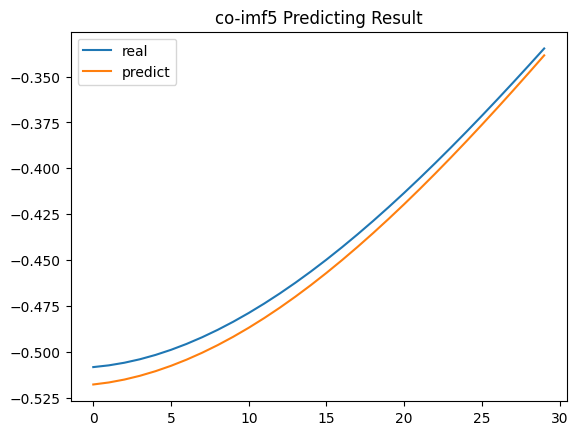

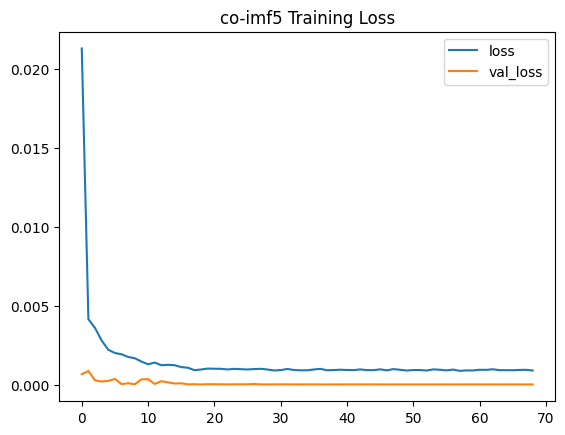

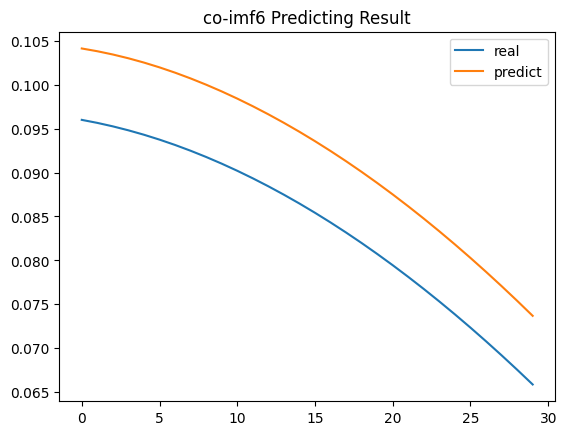

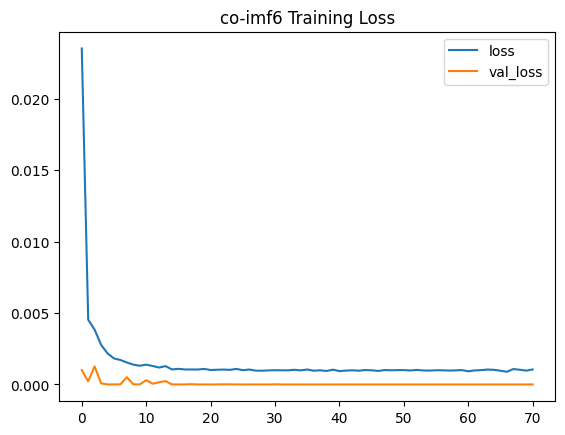

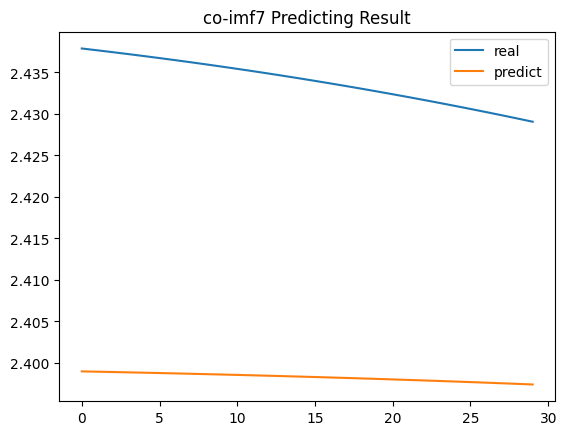

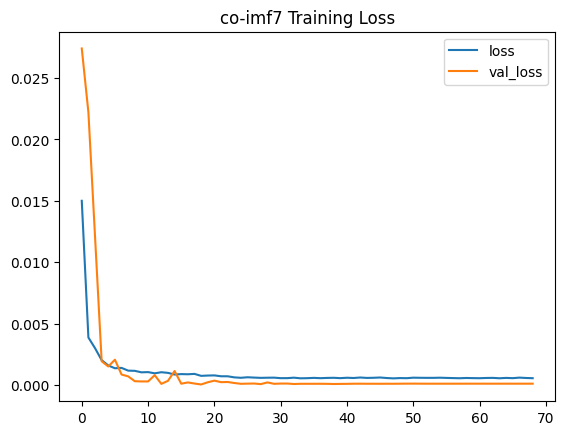

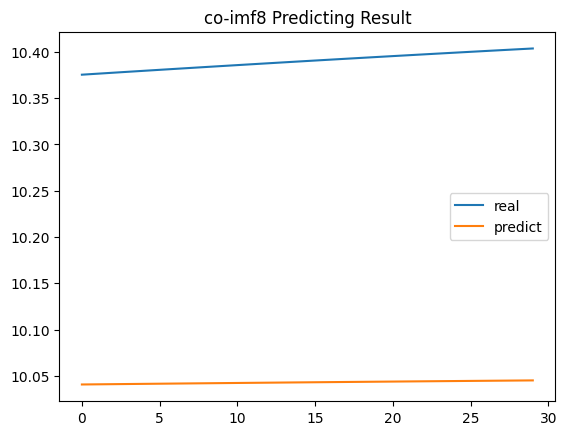

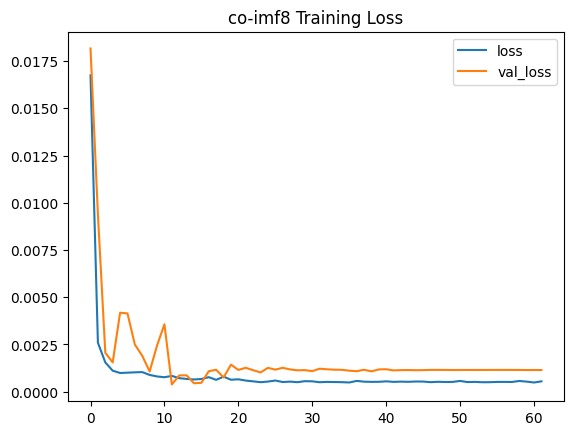

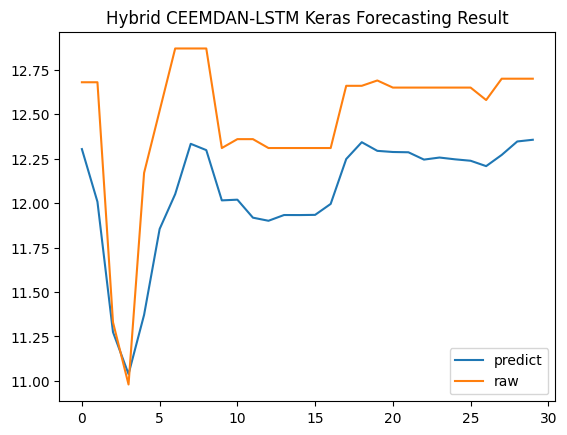

Mean Absolute Error : 0.4148225364685058
Root Mean Squared Error : 0.4457775825850839
Mean Absolute Percentage Error : 0.033034121309282585


In [ ]:
# CL_MODEL(Y, cutoff=30)

##XGBOOST


In [ ]:
def XGraph(modelXG, X_unseen, Y_unseen):
  y_pred = modelXG.predict(X_unseen)
  y_pred = pd.DataFrame(y_pred,index=Y_unseen.index)
  # Plot the results
  plt.plot(y_pred)
  plt.plot(Y_unseen)
  plt.xlabel("Days")
  plt.ylabel("Output")
  plt.legend(["Model","Actual"])
  plt.gcf().autofmt_xdate()
  plt.show()

In [ ]:
def XGBOOST_MODEL(X_train, Y_train, X_test, Y_test, X_unseen, Y_unseen):
  parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
  }
  eval_set = [(X_train, Y_train), (X_test, Y_test)]
  model = xgb.XGBRegressor()
  clf = GridSearchCV(model, parameters)
  clf.fit(X_train, Y_train)

  print(f'Best params: {clf.best_params_}')
  print(f'Best validation score = {clf.best_score_}')

  # Use the best parameters and fit the model
  model = xgb.XGBRegressor(**clf.best_params_, early_stopping = 5, objective='reg:squarederror')
  model.fit(X_train, Y_train, eval_set= [(X_test, Y_test)], verbose=False)

  # Evaluation Stats
  predictions = model.predict(X_test)
  print("Mean Absolute Error : " + str(mean_absolute_error(Y_test, predictions)))
  print("Root Mean Squared Error : " + str(sqrt(mean_squared_error(Y_test, predictions))))
  print("Mean Absolute Percentage Error : " + str(mean_absolute_percentage_error(Y_test, predictions)))

  # Graph the model with unseen data
  XGraph(model, X_unseen, Y_unseen)

In [ ]:
# XGBOOST_MODEL(X_train, Y_train, X_test, Y_test, X_unseen, Y_unseen)

## TRANSFORMER

In [ ]:
def TransformerTensors(data):
  return torch.tensor(data.values, dtype=torch.float32)

def transformer_model(input_shape=(14,), d_model=14):
    inputs = layers.Input(shape=input_shape)

    # Positional encoding
    position = tf.range(start=0, limit=input_shape[0], delta=1)
    position = layers.Embedding(input_shape[0], d_model)(position)

    # Transformer encoder layers
    x = layers.Dense(200, activation='relu')(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.LayerNormalization()(x)

    # Output layer
    outputs = layers.Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def Transformer_Eval(X_Train, Y_Train):
  model = transformer_model()
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X_Train, Y_Train, epochs=20, batch_size=100, validation_split=0.2)

  # Evaluation Stats
  predictions = model.predict(X_test)
  print("Mean Absolute Error : " + str(mean_absolute_error(Y_test, predictions)))
  print("Root Mean Squared Error : " + str(sqrt(mean_squared_error(Y_test, predictions))))
  print("Mean Absolute Percentage Error : " + str(mean_absolute_percentage_error(Y_test, predictions)))

  # Predict the unseen data
  with torch.no_grad():
    y_pred = model(X_unseen.values)
  y_pred = pd.DataFrame(y_pred,index=Y_unseen.index)
  # print(y_pred)
  # Plot the results
  plt.plot(y_pred)
  plt.plot(Y_unseen)
  plt.gcf().autofmt_xdate()
  plt.xlabel("Input")
  plt.ylabel("Output")
  plt.legend(["Model","Actual"])
  plt.show()

In [ ]:
# X_train_tensor = TransformerTensors(X_train)
# Y_train_tensor = TransformerTensors(Y_train)
# X_test_tensor = TransformerTensors(X_test)
# Y_test_tensor = TransformerTensors(Y_test)

# Transformer_Eval(X_train, Y_train)

## ETS Evaluation

This will run through all the ETS datasets and perform all the models.

----------MODEL CONSTRUCTION FOR RGGI----------
----------CEEMDAN-LSTM MODEL CONSTRUCTION FOR RGGI AS BENCHMARK----------
----------XGBOOST MODEL CONSTRUCTION FOR RGGI----------
Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 150, 'random_state': 42}
Best validation score = -3.6899544531561945
Mean Absolute Error : 1.6112799730624605
Root Mean Squared Error : 2.2885869396817364
Mean Absolute Percentage Error : 0.1179626305699197


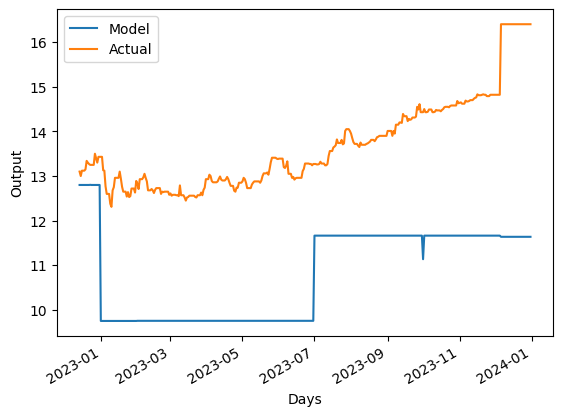

----------TRANSFORMER MODEL CONSTRUCTION FOR RGGI----------
Epoch 1/20
15/15 [==============================] - 2s 31ms/step - loss: 3.1493 - val_loss: 13.0301
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 0.8591 - val_loss: 12.4236
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 0.5928 - val_loss: 10.7983
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 0.4350 - val_loss: 9.4547
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 0.3669 - val_loss: 9.6346
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 0.3432 - val_loss: 9.2023
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 0.3066 - val_loss: 8.6353
Epoch 8/20
15/15 [==============================] - 0s 11ms/step - loss: 0.2955 - val_loss: 8.3380
Epoch 9/20
15/15 [==============================] - 0s 11ms/step - loss: 0.2839 - val_loss: 8.4061
Epoch 10/20
15/15 [===========================

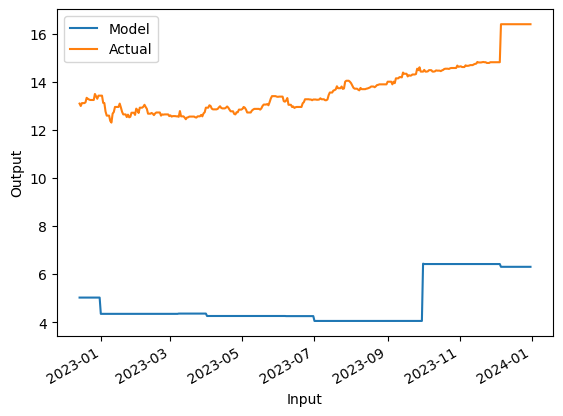

0:02:29.237146
----------ALL MODELS FOR RGGI COMPLETE----------
----------MODEL CONSTRUCTION FOR CA----------
----------CEEMDAN-LSTM MODEL CONSTRUCTION FOR CA AS BENCHMARK----------
----------XGBOOST MODEL CONSTRUCTION FOR CA----------
Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42}
Best validation score = -2.016374403082893
Mean Absolute Error : 5.887865422301131
Root Mean Squared Error : 6.363725712430898
Mean Absolute Percentage Error : 0.19353035214226696


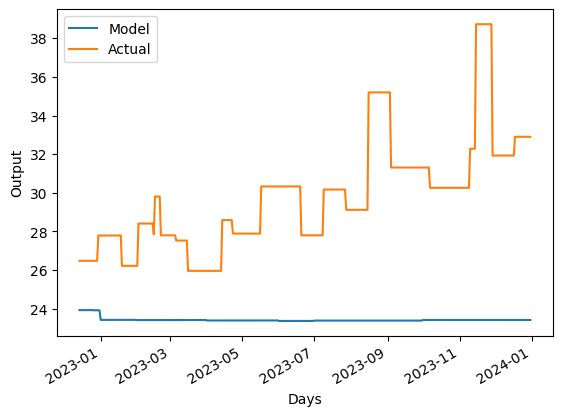

----------TRANSFORMER MODEL CONSTRUCTION FOR CA----------
Epoch 1/20
15/15 [==============================] - 3s 47ms/step - loss: 41.9372 - val_loss: 39.8014
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 2.3041 - val_loss: 25.4756
Epoch 3/20
15/15 [==============================] - 0s 20ms/step - loss: 1.8091 - val_loss: 26.5735
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 1.7886 - val_loss: 24.6572
Epoch 5/20
15/15 [==============================] - 0s 20ms/step - loss: 1.7474 - val_loss: 24.8268
Epoch 6/20
15/15 [==============================] - 0s 21ms/step - loss: 1.7359 - val_loss: 23.7650
Epoch 7/20
15/15 [==============================] - 0s 19ms/step - loss: 1.7197 - val_loss: 24.2951
Epoch 8/20
15/15 [==============================] - 0s 13ms/step - loss: 1.7073 - val_loss: 22.9489
Epoch 9/20
15/15 [==============================] - 0s 12ms/step - loss: 1.6942 - val_loss: 23.1496
Epoch 10/20
15/15 [======================

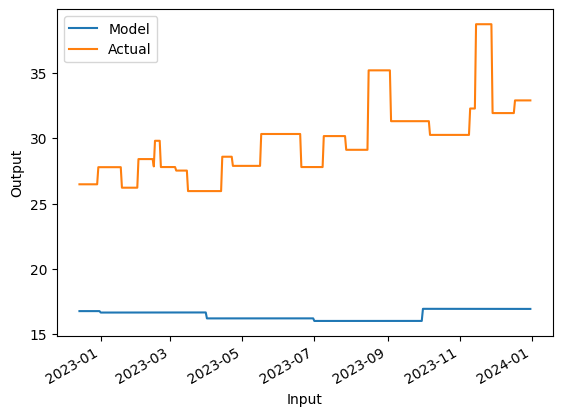

0:04:52.350854
----------ALL MODELS FOR CA COMPLETE----------
----------MODEL CONSTRUCTION FOR Korea----------
----------CEEMDAN-LSTM MODEL CONSTRUCTION FOR Korea AS BENCHMARK----------
----------XGBOOST MODEL CONSTRUCTION FOR Korea----------
Best params: {'gamma': 0.001, 'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42}
Best validation score = -1.4066685477822163
Mean Absolute Error : 5.658800137671727
Root Mean Squared Error : 6.33578117664895
Mean Absolute Percentage Error : 0.3191845674010119


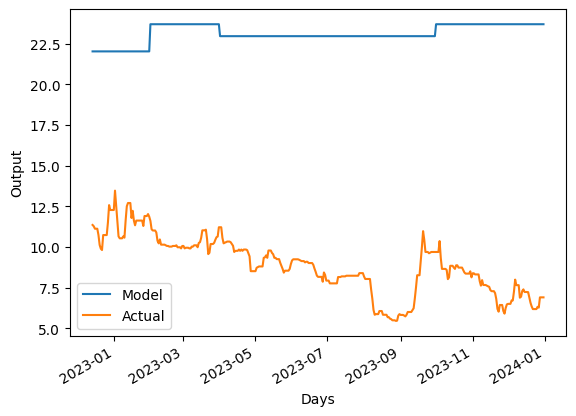

----------TRANSFORMER MODEL CONSTRUCTION FOR Korea----------
Epoch 1/20
15/15 [==============================] - 2s 30ms/step - loss: 154.8387 - val_loss: 29.5969
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 43.8021 - val_loss: 21.8735
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 27.3834 - val_loss: 25.3767
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 22.5165 - val_loss: 30.4995
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 21.7488 - val_loss: 32.7395
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 21.6355 - val_loss: 32.0619
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 21.6009 - val_loss: 31.2236
Epoch 8/20
15/15 [==============================] - 0s 11ms/step - loss: 21.5445 - val_loss: 31.3006
Epoch 9/20
15/15 [==============================] - 0s 11ms/step - loss: 21.5088 - val_loss: 31.6153
Epoch 10/20
15/15 [==========

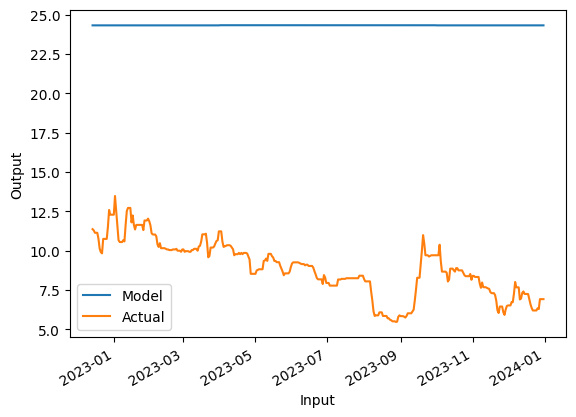

0:07:19.839219
----------ALL MODELS FOR Korea COMPLETE----------
----------MODEL CONSTRUCTION FOR EU----------
----------CEEMDAN-LSTM MODEL CONSTRUCTION FOR EU AS BENCHMARK----------
----------XGBOOST MODEL CONSTRUCTION FOR EU----------
Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 150, 'random_state': 42}
Best validation score = -5.2292253939681
Mean Absolute Error : 20.325174193220413
Root Mean Squared Error : 23.709074724823118
Mean Absolute Percentage Error : 0.22696858945107987


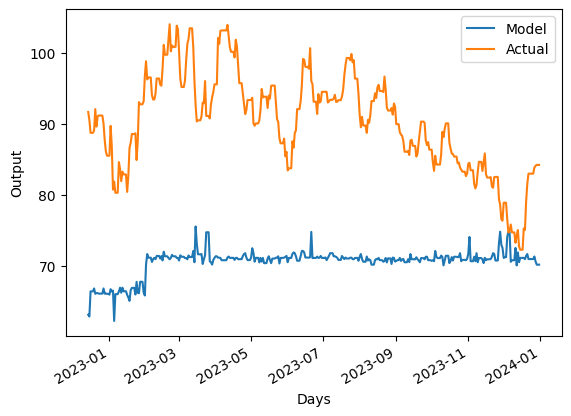

----------TRANSFORMER MODEL CONSTRUCTION FOR EU----------
Epoch 1/20
15/15 [==============================] - 2s 32ms/step - loss: 179.3877 - val_loss: 1898.9436
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 94.8962 - val_loss: 1691.8268
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 88.5692 - val_loss: 1597.0791
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 87.8626 - val_loss: 1577.2637
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 87.6887 - val_loss: 1596.9407
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 87.4481 - val_loss: 1632.5685
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 87.2654 - val_loss: 1642.7423
Epoch 8/20
15/15 [==============================] - 0s 11ms/step - loss: 86.7345 - val_loss: 1642.2751
Epoch 9/20
15/15 [==============================] - 0s 11ms/step - loss: 86.1850 - val_loss: 1691.0571
Epoch 10/20
15

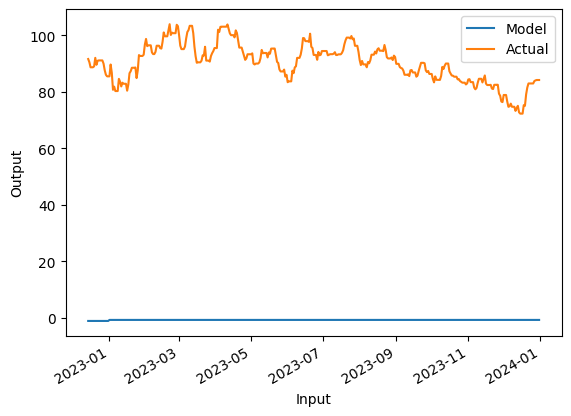

0:12:19.350588
----------ALL MODELS FOR EU COMPLETE----------
----------MODEL CONSTRUCTION FOR China----------
----------CEEMDAN-LSTM MODEL CONSTRUCTION FOR China AS BENCHMARK----------
----------XGBOOST MODEL CONSTRUCTION FOR China----------
Best params: {'gamma': 0.02, 'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 150, 'random_state': 42}
Best validation score = -0.07087479649130272
Mean Absolute Error : 3.3277192052537408
Root Mean Squared Error : 3.8384103139012757
Mean Absolute Percentage Error : 0.3464129676207806


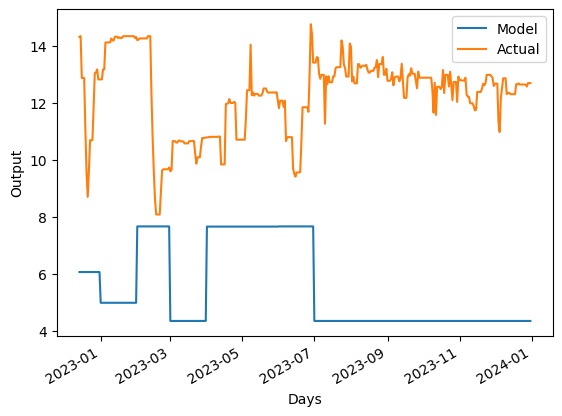

----------TRANSFORMER MODEL CONSTRUCTION FOR China----------
Epoch 1/20
15/15 [==============================] - 2s 47ms/step - loss: 9.3560 - val_loss: 6.4501
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 6.3748 - val_loss: 7.0408
Epoch 3/20
15/15 [==============================] - 0s 21ms/step - loss: 6.1307 - val_loss: 6.5808
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 6.0582 - val_loss: 6.3928
Epoch 5/20
15/15 [==============================] - 0s 20ms/step - loss: 6.1058 - val_loss: 6.2811
Epoch 6/20
15/15 [==============================] - 0s 23ms/step - loss: 6.0306 - val_loss: 6.4435
Epoch 7/20
15/15 [==============================] - 0s 21ms/step - loss: 6.1075 - val_loss: 6.3537
Epoch 8/20
15/15 [==============================] - 0s 20ms/step - loss: 6.0562 - val_loss: 6.3131
Epoch 9/20
15/15 [==============================] - 0s 20ms/step - loss: 6.0278 - val_loss: 6.3332
Epoch 10/20
15/15 [=============================

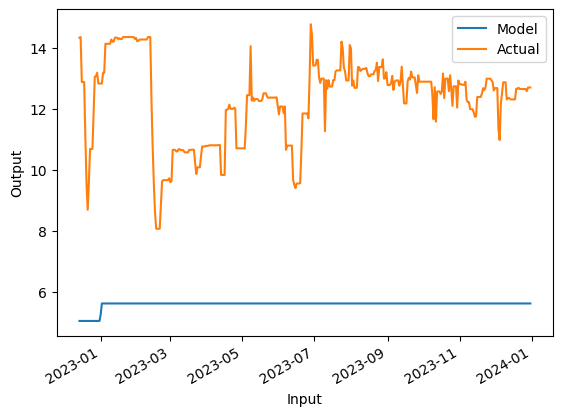

0:14:52.075300
----------ALL MODELS FOR China COMPLETE----------
----------ETS MODULE FORMATS COMPLETE----------


In [ ]:
markets = ["RGGI","CA","Korea","EU","China"]
now = dt.datetime.now()
for ETS in markets:
  print('----------MODEL CONSTRUCTION FOR {}----------'.format(ETS))
  X, Y, X_train, X_test, Y_train, Y_test, X_unseen, Y_unseen, cutoff = DataForm(ETS, .15)
  print('----------CEEMDAN-LSTM MODEL CONSTRUCTION FOR {} AS BENCHMARK----------'.format(ETS))
  # CL_MODEL(Y, cutoff=30)
  print('----------XGBOOST MODEL CONSTRUCTION FOR {}----------'.format(ETS))
  XGBOOST_MODEL(X_train, Y_train, X_test, Y_test, X_unseen, Y_unseen)
  print('----------TRANSFORMER MODEL CONSTRUCTION FOR {}----------'.format(ETS))
  Transformer_Eval(X_train, Y_train)
  print(dt.datetime.now()-now)
  print('----------ALL MODELS FOR {} COMPLETE----------'.format(ETS))

print('----------ETS MODULE FORMATS COMPLETE----------'.format(ETS))